In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# For optimization using pygmo
import pygmo as pg
import numpy as np
from udp_initial_condition import udp_initial_condition

# For Plotting
import matplotlib.pyplot as plt

# For cProfile evaluation
import cProfile
import pstats

In [3]:
# Setup hyperparameters:
body_density = 533                  # https://sci.esa.int/web/rosetta/-/14615-comet-67p
target_altitude = 5000**2           # Target altitude squared
final_time = 20*3600.0              # Final time
start_time = 0                      # Starting time
time_step = 800.0              # Time step size for trajectory propagation.

# Bounds for initial variable domain: [r_x,r_y,r_z,v_x,v_y,v_z]
lower_bounds, upper_bounds = [-6000,-6000,-6000,0,0,0],[6000,6000,6000,2.5,2.5,2.5]

# Optimization parameters
population_size = 10
number_of_generations = 32

Physical dimension along x (UN-normalized):  5002.5703125 Km
Problem name: <class 'udp_initial_condition.udp_initial_condition'>
	C++ class name: pybind11::object

	Global dimension:			6
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [-6000, -6000, -6000, 0, 0, ... ]
	Upper bounds: [6000, 6000, 6000, 2.5, 2.5, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none


   Gen:        Fevals:          Best:             F:            CR:            dx:            df:
      1             10    2.01782e+09       0.499094       0.216494        13612.2    2.43676e+10
      2             20    2.01782e+09       0.499094       0.216494        16159.6    9.95702e+09
      3             30    1.60605e+09       0.499094     

BokehModel(combine_events=True, render_bundle={'docs_json': {'261587ec-c6a1-4e98-9652-e7976a2da218': {'defs': …

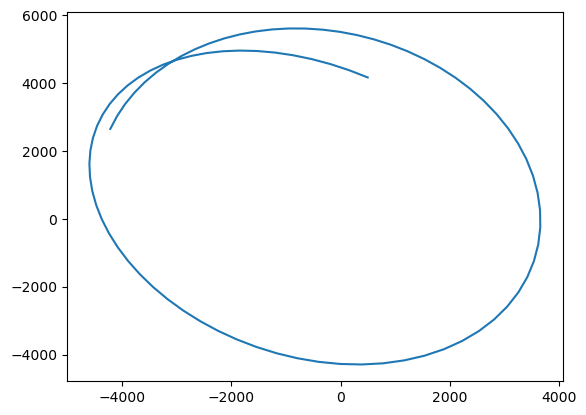

In [27]:
# Setup class
udp = udp_initial_condition(body_density, target_altitude, final_time, start_time, time_step, lower_bounds, upper_bounds)

# Setup user defined problem (udp)
prob = pg.problem(udp)
print(prob)

# Setup optimization algorithm
algo = pg.algorithm(pg.sade(gen = number_of_generations))
pop = pg.population(prob = prob, size = population_size)

# Run optimization
algo.set_verbosity(1)
pop = algo.evolve(pop)

# Logs for output
print("Champion fitness value: ", pop.champion_f) 
print("Champion chromosome: ", pop.champion_x) 

# Retrieving champion chromosome
x = pop.champion_x

# Compute optimized trajectory
fit_val, r_store, v_store, a_store = udp.compute_trajectory(x)

# Plot optimized trajectory
udp.plot_trajectory(r_store)

plt.plot(r_store[1],r_store[2])

In [20]:
# Plot optimized trajectory
udp.plot_trajectory(r_store)

BokehModel(combine_events=True, render_bundle={'docs_json': {'b51fa9fd-ece7-4cf2-9bac-e488e3b9ba6d': {'defs': …